# Find Microglia

This notebooks runs several Laplacian on Gaussian filters to find microglia cells. It is only used for localization as it assumes a blob-like share, which is only true with large smoothing

## Activate environment and imports

The packages needed are specified in `../Project.toml` file. The foolowwing activates that environmet so we can find the packages we need

In [1]:
]activate ../

Activating environment at `~/projects/borton/calcium-roi-analysis/Project.toml`


In [2]:
using Revise #This allows for changes to files to be picked up without restarting kernel
using Images
using ImageFiltering
using ImageBinarization
using ImageSegmentation
using StatsBase
using Plots
using NPZ
using YAML
Revise.includet("../julia_src/utils.jl")

## Napari
The following is to import napari and relies on the Python environmet in the parent folder

In [3]:
using PyCall
# Needed for napari
pygui_start(:qt5)
# needed to kickstart Qt5 for some reason
qapp_obj = pyimport("qtpy.QtWidgets").QApplication([""])
napari = pyimport("napari")
skimage = pyimport("skimage")

PyObject <module 'skimage' from '/Users/mrestrep/projects/borton/calcium-roi-analysis/.venv/lib/python3.8/site-packages/skimage/__init__.py'>

## Import parameters and read in data

In [4]:
params, data_path, output_path = prepare_paths("../parameters/current.yaml")

(Dict{Any,Any}("radius" => [5.0, 7.0, 9.0],"output_base_path" => "/Users/mrestrep/projects/borton/calacium_images/sophie_data/julia_output","input_tiff_dir" => "/Users/mrestrep/projects/borton/calacium_images/sophie_data/tiffs"), "/Users/mrestrep/projects/borton/calacium_images/sophie_data/tiffs", "/Users/mrestrep/projects/borton/calacium_images/sophie_data/julia_output")

In [5]:
voi = load_tiffstack(data_path);
voi_napari = convert(Array{Float64}, voi);
radius = params["radius"]

3-element Array{Float64,1}:
 5.0
 7.0
 9.0

## Run Laplacian of Gaussian filters

The size is determined by the values of the radius specified in the parameter file. We assume isotropic shape.

In [6]:
blob_sigmas = round.(radius./sqrt(2.))
blob_shape = [1.0, 1.0, 1.0]

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

In [7]:
voi_filtered = fill(zeros(eltype(voi), size(voi)), length(radius))
for (i,sigma) in enumerate(blob_sigmas)
    voi_filtered[i] = imfilter(voi, Kernel.gaussian((sigma,sigma,sigma)))
end

In [8]:
println("Finding blobs")
# The true allowd finding blobs in edge pixels, can try setting to false, but I have often found to few blobs that way
@time blobs = blob_LoG(voi, blob_sigmas, true, blob_shape)
n_blobs = length(blobs)
println("Found  $n_blobs blobs")

Finding blobs
 14.407060 seconds (3.07 M allocations: 8.833 GiB, 8.23% gc time)
Found  5297 blobs


In [9]:
blob_x = zeros(Int64, length(blobs))
blob_y = zeros(Int64, length(blobs))
blob_z = zeros(Int64, length(blobs))
amplitude = zeros(Float64, length(blobs))
σ = zeros(Float64, length(blobs))

for i=1:length(blobs)
    coord = blobs[i].location
    blob_x[i]  = coord[1]
    blob_y[i] = coord[2]
    blob_z[i] = coord[3]
    amplitude[i] = blobs[i].amplitude
    σ[i] = blobs[i].σ
end


## Plot Histogram of Amplitude¶
This sets the initial threshold to set in napari.


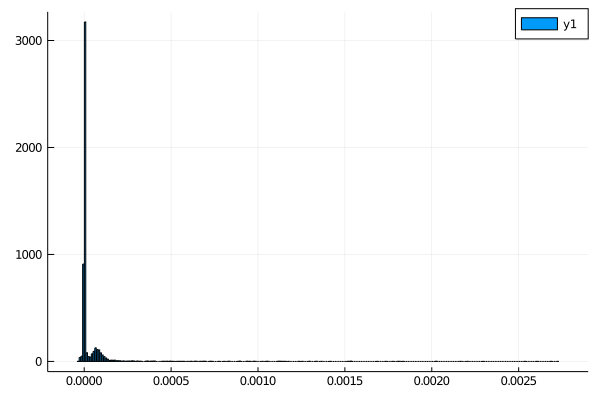

In [10]:
# intensity_scale = 20
h = fit(Histogram, amplitude; nbins=500)
bar(midpoints(h.edges...), h.weights)

In [11]:
t_val = maximum(h.weights) - 100
t = midpoints(h.edges...)[findall(h.weights.>t_val)] .+ 0.0001
thresh = t[1]

0.000105

## Save Data

In [12]:
valid = amplitude .> thresh
blobs_array = [ blob_x blob_y blob_z ]
sigma_string = replace(join(string.(blob_sigmas), '-'), "." => "_")
fout = output_path * "/blobs-data-$(sigma_string).npz"
npzwrite(fout, Dict("coords"=>blobs_array, 
                    "class_label"=>valid, 
                    "confidence"=>amplitude,
                    "sigma" => σ,
                    "threshold"=>thresh))

## (Re)Load Data

In [13]:
data = npzread(fout)

Dict{String,Any} with 5 entries:
  "sigma"       => [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0  …  4.0, 4…
  "threshold"   => 0.000105
  "class_label" => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0…
  "coords"      => [63 1 1; 96 1 1; … ; 496 512 54; 512 512 54]
  "confidence"  => [1.94969e-6, 4.48598e-8, 1.98018e-6, 1.52618e-6, -3.24593e-7…

## Visualization in Napari and threshold selection

In [26]:
review_points = data["coords"]
class_labels = data["class_label"]    
review_properties = Dict(
 "confidence" => data["confidence"],
 "good_point" => class_labels)
confidence_t = data["threshold"]
face_color_cycle = [[0, 0, 1, 0.5], [0, 1, 0, 0.5]]
### Napari show layers
viewer = napari.view_image(voi_napari, rgb=false, name="raw")
for (i,sigma) in enumerate(blob_sigmas)
    viewer.add_image(convert(Array{Float64},voi_filtered[i]), name = "sigma = $sigma")
end
points_layer = viewer.add_points(review_points,
                 face_color="good_point",
                 edge_color=[1, 1, 1, 0],
                 face_color_cycle=face_color_cycle,
                 name="all points",
                 size=data["sigma"],
                 properties=review_properties)
show_bad_points = true
# viewer.bind_key("h", hide_bad_points)

true

In [ ]:
println("hi")

In [25]:
review_points[data["sigma"].==5.0, :]

1×3 Array{Int64,2}:
 468  234  1

In [19]:
blob_sigmas

3-element Array{Float64,1}:
 4.0
 5.0
 6.0